# IMPORTS

In [1]:
from novelty_detection.data import load_data, save_img, save_data
from novelty_detection.preprocessing import *
from novelty_detection.decision_plots import *

#load preprocessed data
data = load_data("prediction_gaia_data.csv")

In [2]:
x_columns = ['Day', 'T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Diff_temp',
           'Hours_sin', 'Hours_cos', 'T_ret'] 

y_column = ['T_ret_in_1h']

# SPLIT

In [4]:
day_for_training = 14
data_for_train = data[data['Day'] != day_for_training]
data_for_test = data[data['Day'] == day_for_training]

train_x = data_for_train[x_columns]
train_y = data_for_train[y_column]

test_x = data_for_test[x_columns]
test_y = data_for_test[y_column]

print('len train', train_x.shape[0])
print('len test', test_x.shape[0])

len train 5264
len test 376


# SCALING

In [5]:
from novelty_detection.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters

mu_x = train_x.mean(0)
s_x = train_x.std(0)

mu_y = train_y.mean(0)
s_y = train_y.std(0)

max_x = train_x.max(0)
min_x = train_x.min(0)

max_y = train_y.max(0)
min_y = train_y.min(0)

train_x_norm = std_scaler_given_parameters(train_x, mu_x, s_x)
test_x_norm = std_scaler_given_parameters(test_x, mu_x, s_x)
train_y_norm = std_scaler_given_parameters(train_y, mu_y, s_y)
test_y_norm = std_scaler_given_parameters(test_y, mu_y, s_y)

# train_x_norm = minmax_scaler_given_parameters(train_x,  max_val=max_x, min_val=min_x, feature_range=[0,1])
# test_x_norm = minmax_scaler_given_parameters(test_x,  max_val=max_x, min_val=min_x, feature_range=[0,1])
# train_y_norm = minmax_scaler_given_parameters(train_y,  max_val=max_y, min_val=min_y, feature_range=[0,1])
# test_y_norm = minmax_scaler_given_parameters(test_y,  max_val=max_y, min_val=min_y, feature_range=[0,1])

# ANFIS TRAINING

In [17]:
from novelty_detection.anfis import ANFIS

# Example of use
fis = ANFIS(n_inputs=7, n_rules=8, learning_rate=1e-4, mf='gbellmf',defuzz_method='linear', loss_fun='huber', init_method='normal')
fis.compile(run_eagerly=True)

# For training
fis.fit(train_x_norm, train_y_norm, epochs=175, batch_size=32)

# For evaluation
val_loss = fis.evaluate(test_x_norm, test_y_norm)
print("Validation loss:", val_loss)




Epoch 1/175
165/165 [==============================] - 4s 25ms/step - loss: 0.4529
Epoch 2/175
165/165 [==============================] - 4s 24ms/step - loss: 0.4292
Epoch 3/175
165/165 [==============================] - 4s 24ms/step - loss: 0.4205
Epoch 4/175
165/165 [==============================] - 4s 24ms/step - loss: 0.4133
Epoch 5/175
165/165 [==============================] - 4s 25ms/step - loss: 0.4023
Epoch 6/175
165/165 [==============================] - 4s 24ms/step - loss: 0.3931
Epoch 7/175
165/165 [==============================] - 4s 24ms/step - loss: 0.3842
Epoch 8/175
165/165 [==============================] - 4s 25ms/step - loss: 0.3801
Epoch 9/175
165/165 [==============================] - 4s 24ms/step - loss: 0.3745
Epoch 10/175
165/165 [==============================] - 4s 25ms/step - loss: 0.3708
Epoch 11/175
165/165 [==============================] - 4s 24ms/step - loss: 0.3659
Epoch 12/175
165/165 [==============================] - 4s 25ms/step - loss: 0.361

12/12 [==============================] - 0s 3ms/step


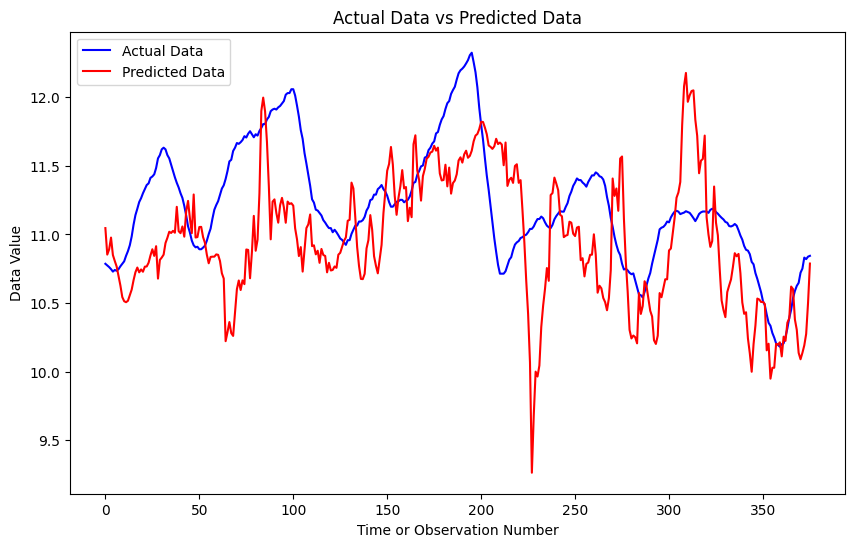

In [ ]:
input_data = test_x_norm.to_numpy() 
time = np.arange(0,len(test_y_norm))

# Generate predictions
predicted_data = fis.predict(input_data)

a=s_y*test_y_norm+mu_y
predicted_data_df = pd.DataFrame()
predicted_data_df['T_ret_in_1h']=pd.Series(predicted_data)
b=s_y*predicted_data_df+mu_y

error_sum = (np.sum(abs(a.to_numpy()-b.to_numpy())))
error_avg = (np.mean(abs(a.to_numpy()-b.to_numpy())))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, a, label='Actual Data', color='blue')
plt.plot(time, b, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.figtext(.95, 0.8, f"error_sum = {error_sum}") 
plt.figtext(.95, 0.8, f"error_avg = {error_avg}") 

plt.legend()
plt.show()